In [9]:
%reload_ext autoreload
%autoreload 2
import torch
import os 

import pandas as pd
import numpy as np
# # import scanpy as sc
# import os
# # from sklearn.model_selection import train_test_split
# import torch
# from torch import nn, optim
# from torch.utils.data import DataLoader, Dataset
# from torch.nn import functional as F
# from torch.autograd import Variable
# from sklearn.preprocessing import MinMaxScaler

# import functions as fx
# import models as mx
# import run as rx

# import torch
# import pandas as pd
# import umap
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import matplotlib.pylab as plt

# import time
# import torch
# from matplotlib import pyplot as plt
# from pykeops.torch import LazyTensor

# import multiprocessing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
df = pd.read_pickle('results/fulldata/x_train.pickle')
dfz = pd.read_pickle('results/fulldata/latent_nonpd1.pickle')

In [2]:
def KMeans(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c

In [5]:
use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
device_id = "cuda:0" if use_cuda else "cpu"
N, D, K = 10000, 2, 50

x = 0.7 * torch.randn(N, D, dtype=dtype, device=device_id) + 0.3

cl, c = KMeans(x, K)


NameError: name 'time' is not defined

In [ ]:
cl

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=50, alpha=0.8)
plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()

In [2]:
import torch
import scipy.spatial
from torch_cluster import knn

In [32]:
import clustering

a = torch.tensor([[ 0.9722, -1.5786, -1.3693,  0.3016,  2.1844],
           [-0.9048, -1.1370, -0.2596,  0.9444,  1.4554],
            [ 0.0236,  1.3403, -1.0269,  1.4283,  1.5248],
              [-0.4894,  1, -2.3708,  0.7294, -0.1721],
                   [-0.4894,  0.3441, -2.3708,  0.7294, -0.1721]
]).to(device)

b = torch.LongTensor([0, 1, 2, 3])

c = torch.tensor([
    [-0.4894,  0.3441, -2.3708,  0.7294, -0.1721]
]).to(device)

dist = torch.norm(a - c, dim=1, p=None)
knn = dist.topk(2, largest=False)

In [33]:
knn

torch.return_types.topk(
values=tensor([0.0000, 0.6559], device='cuda:0'),
indices=tensor([4, 3], device='cuda:0'))

In [26]:
y

tensor([[-0.4894,  0.3441, -2.3708,  0.7294, -0.1721]], device='cuda:0')

In [10]:
temp = dfz.iloc[:5]
source0 = temp[temp.source==0].drop(columns="source")
source_n0 = temp[temp.source!=0].drop(columns="source")
# assign_index = knn(source0, source_n0, 2)
x = torch.tensor(source0.values.astype(np.float32)).to(device)
y = torch.tensor(source_n0.values.astype(np.float32)).to(device)


dist = torch.norm(x - y, dim=1, p=None)

knn = dist.topk(2, largest=False)

In [11]:
source0

,0,1,2,3,4
id,,,,,
s0pt88_8023,0.972227,-1.578553,-1.369311,0.301595,2.184441
s0pt161_82476,-0.904781,-1.137039,-0.259605,0.944401,1.455388
s0pt91_597,0.023647,1.340321,-1.026875,1.428309,1.524810
s0pt34_42066,0.709087,1.181129,-0.672512,-1.005812,0.043640


In [12]:
source_n0

,0,1,2,3,4
id,,,,,
s1pt34_28031,-0.489359,0.344072,-2.370759,0.729445,-0.172081


In [13]:
print('kNN dist: {}, index: {}'.format(knn.values, knn.indices))

kNN dist: tensor([2.5357, 2.8423], device='cuda:0'), index: tensor([2, 3], device='cuda:0')


In [5]:
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1], [-1, 0], [1, 0], [1, -1], [-1, 0]]).to(device)
y = torch.Tensor([[-1, 0], [1, 0], [-1, 0], [1, 0]]).to(device)

dist = torch.norm(x - y, dim=1, p=None)
knn = dist.topk(3, largest=False)

print('kNN dist: {}, index: {}'.format(knn.values, knn.indices))

RuntimeError: The size of tensor a (8) must match the size of tensor b (4) at non-singleton dimension 0

In [7]:
# data = torch.randn(100, 10)
# test = torch.randn(1, 10)

# dist = torch.norm(data - test, dim=1, p=None)
# knn = dist.topk(3, largest=False)

# print('kNN dist: {}, index: {}'.format(knn.values, knn.indices))
# data

In [3]:
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1], [-1, 0], [1, 0], [1, -1], [-1, 0]]).to(device)
batch_x = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1])
y = torch.Tensor([[-1, 0], [1, 0], [-1, 0], [1, 0]]).to(device)
batch_y = torch.tensor([0, 0, 1, 1])
assign_index = knn(x, y, 4)
print(assign_index)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/nobackup/users/ifrah/projects/condas/cytof/miniconda3/envs/cytof/lib/python3.9/site-packages/torch_cluster/knn.py", line 70, in knn
        ptr_y = torch.bucketize(arange, batch_y)

    return torch.ops.torch_cluster.knn(x, y, ptr_x, ptr_y, k, cosine,
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
                                       num_workers)
RuntimeError: Not compiled with CUDA support


In [ ]:
def transform_indices(indices_df):    
    # Transforms indices of nearest neighbors from sample to fit the indices of the larger dataframe.
    indices_new = np.array([indices_df.index[x] for x in indices_df.values.flatten()]).reshape(indices_df.shape)
    indices_new = pd.DataFrame(indices_new, index=indices_df.index)
    return indices_new

In [4]:
df = pd.read_pickle('results/fulldata/x_train.pickle')
dfz = pd.read_pickle('results/fulldata/latent_nonpd1.pickle')

NameError: name 'pd' is not defined

In [5]:
dfz = pd.read_pickle('results/fulldata/latent_nonpd1.pickle')

NameError: name 'pd' is not defined

In [11]:
# Make a umap of the latent space
def computeUMAProjectionOfLatentSpace(df, display=True):
    
    df = df.sample(10000)
    latent = df.drop(columns=["source"])

    # Compute t-SNE embedding of latent space
    print("Computing umap embedding...")
    model = umap.UMAP(n_components=2, random_state=0)
    X_umap = model.fit_transform(latent)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting umap visualization...")
        plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df.source)
        plt.show()
    else:
        return X_umap

Computing umap embedding...
Plotting umap visualization...


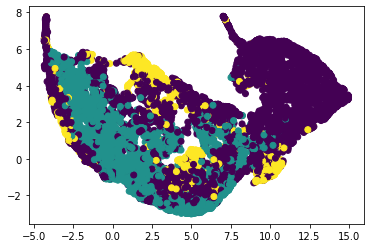

In [12]:
computeUMAProjectionOfLatentSpace(df)

Computing umap embedding...
Plotting umap visualization...


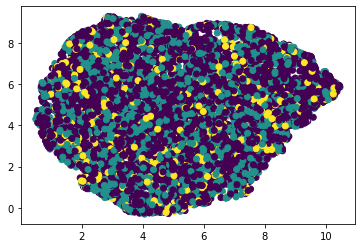

In [13]:
computeUMAProjectionOfLatentSpace(dfz)

In [ ]:
# Step 1: Get the distances matrix
sample = dfz#.sample(1000)
sample_clean = sample.drop(columns=["source"])
nrst_neigh = NearestNeighbors(n_neighbors = 10, algorithm = 'auto')
nrst_neigh.fit(sample_clean)
distances, indices = nrst_neigh.kneighbors(sample_clean)

In [19]:
import torch
import scipy.spatial
from torch_cluster import knn

In [20]:
if torch.cuda.is_available():
    import torch_cluster.knn_cuda

ModuleNotFoundError: No module named 'torch_cluster.knn_cuda'

In [16]:
source_n0

,0,1,2,3,4
id,,,,,
s1pt34_28031,-0.489359,0.344072,-2.370759,0.729445,-0.172081


In [21]:
temp = dfz.iloc[:5]
source0 = temp[temp.source==0].drop(columns="source")
source_n0 = temp[temp.source!=0].drop(columns="source")
# assign_index = knn(source0, source_n0, 2)
x = torch.tensor(source0.values.astype(np.float32)).to(device)
y = torch.tensor(source_n0.values.astype(np.float32)).to(device)

assign_index = knn(x, y, 4)
assign_index

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/nobackup/users/ifrah/projects/condas/cytof/miniconda3/envs/cytof/lib/python3.9/site-packages/torch_cluster/knn.py", line 70, in knn
        ptr_y = torch.bucketize(arange, batch_y)

    return torch.ops.torch_cluster.knn(x, y, ptr_x, ptr_y, k, cosine,
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
                                       num_workers)
RuntimeError: Not compiled with CUDA support


In [17]:
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1], [-1, 0], [1, 0], [1, -1], [-1, 0]]).to(device)
batch_x = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1])
y = torch.Tensor([[-1, 0], [1, 0], [-1, 0], [1, 0]]).to(device)
batch_y = torch.tensor([0, 0, 1, 1])
assign_index = knn(x, y, 4)
print(assign_index)

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [4, 7, 0, 1, 5, 2, 3, 6, 4, 7, 0, 1, 5, 2, 3, 6]])


In [ ]:
indices_df = pd.DataFrame(indices, index=sample_clean.index, dtype="Int64")
indices_df['source'] = sample.source
indices_df.to_csv('results/fulldata/nn_indices.csv')

distances_df = pd.DataFrame(distances, index=sample_clean.index)
distances_df['source'] = sample.source
distances_df.to_csv('results/fulldata/nn_distances.csv')


In [7]:
# indices_df = pd.read_csv('results/fulldata/nn_indices.csv', index_col="id")

In [9]:
# indices_df = transform_indices(pd.read_csv('results/fulldata/nn_indices.csv', index_col="id"))

In [ ]:
set(sample.source)

In [ ]:
# Replace all the neighbors from the same source with NaNs
source0 = indices_df[sample.source==0]
s0_ids = list(source0.index)

source1 = indices_df[sample.source==1]
s1_ids = list(source1.index)

source2 = indices_df[sample.source==2]
s2_ids = list(source2.index)


s0_indices = source0.replace(s0_ids, np.NaN)
s1_indices = source1.replace(s1_ids, np.NaN)
s2_indices = source2.replace(s2_ids, np.NaN)

In [27]:
ori = pd.read_csv("../data/processed/fulldata/mitsialis_bengsch_rahman_all.csv", index_col="id")

In [28]:
ori

,BEADS,CENTER,AHR,IL1B,CXCR3,CD161,CD24,CCR6,CD123,CD45RA,...,CD45_159,41BB,HO165DI,BTLA,ER168DI,GRANZYMEB,GITR,YB176DI,OS189DI,CISPLATIN
id,,,,,,,,,,,,,,,,,,,,,
s0pt0_0,0.0,460.180,4.426606,1.649241,68.041640,1.834118,0.0,0.000000,0.0000,2.964842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0pt0_1,0.0,460.306,0.000000,0.094052,47.596527,0.000000,0.0,1.628844,0.3416,22.856253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0pt0_10,0.0,487.402,1.229172,0.319999,48.530052,56.886467,0.0,11.776571,0.0000,0.934674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0pt0_100,0.0,503.194,7.175693,0.000000,29.998308,0.569988,0.0,1.437091,0.0000,17.747616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0pt0_1000,0.0,574.591,0.626138,3.391332,0.512507,16.447502,0.0,0.555181,0.1025,0.364737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s2pt9_995,NaN,NaN,NaN,NaN,20.513000,12.178000,NaN,0.000000,NaN,0.000000,...,168.221,1.646,0.000,1.045,0.0,0.519,0.000,0.000,0.0,40.423
s2pt9_996,NaN,NaN,NaN,NaN,12.241000,48.590000,NaN,5.338000,NaN,0.000000,...,651.531,184.294,0.640,0.656,0.0,5.028,0.000,19.591,0.0,135.802
s2pt9_997,NaN,NaN,NaN,NaN,5.545000,29.345000,NaN,5.528000,NaN,4.481000,...,293.643,63.256,0.485,1.336,0.0,0.000,0.000,0.000,0.0,36.713


In [ ]:
ori0 = ori.loc[s0_ids,:]
ori1 = ori.loc[s1_ids,:]
ori2 = ori.loc[s2_ids,:]


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

temp_ori = ori.drop(columns=['source'])
non_missing_columns = list(temp_ori[temp_ori.columns[~temp_ori.isnull().any()]].columns)

imputed_df = pd.DataFrame()

indices = list(indices_df.index)[:10]

for x in indices:
    sample = temp_ori.loc[x]
    sample_nans = temp_ori.loc 
    # Get the indices of all the neighbors from differnt sources (we set same source to be na)
    nn_indices = indices_df.loc[x,:].dropna() 
    # Get the actual neighbor samples
    neighbors = temp_ori.loc[nn_indices,:]
    # Get the markers that need to be imputed
    missing_markers = list(sample[sample.isna()].index)
    # # Get the mean for each marker from the neighbors 
    imputed_markers = pd.DataFrame(neighbors.mean()).T
    imputed_df = pd.concat([imputed_df, imputed_markers])

imputed_df.index = indices

# Get the existing markers
non_missing_imputed_df = imputed_df[non_missing_columns]
non_missing_ori = temp_ori[non_missing_columns]

non_missing_ori = non_missing_ori.loc[non_missing_imputed_df.index, non_missing_imputed_df.columns]
mse = mean_squared_error(non_missing_ori, non_missing_imputed_df)
mse

In [ ]:
non_missing_imputed_df.head(2)

In [ ]:
non_missing_ori.head(2)